In [1]:
import os, glob
import numpy as np
import pyvista as pv

# === 路径设定 ===
base_dir = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\9_classification"
output_dir = r"D:\github\Phd_summary\3_Result\1_Brava\1_Centerline\4_MeanCenterline"
os.makedirs(output_dir, exist_ok=True)

CLASSES = ["U", "V", "C", "S"]
N_POINTS = 120  # 每条中心线点数一致

def save_polyline(points, path):
    """保存折线为 VTK"""
    line = pv.lines_from_points(points)
    line.save(path)

for cls in CLASSES:
    cls_dir = os.path.join(base_dir, cls)
    vtk_files = sorted(glob.glob(os.path.join(cls_dir, "*.vtk")))
    if not vtk_files:
        print(f"{cls}: 无文件，跳过。")
        continue

    aligned_pts = []
    for f in vtk_files:
        pts = pv.read(f).points
        if pts.shape[0] != N_POINTS:
            print(f"⚠ {f} 点数不符，跳过。")
            continue
        # 平移，使起点在原点
        pts = pts - pts[0]
        aligned_pts.append(pts)

    mean_pts = np.mean(np.stack(aligned_pts), axis=0)
    out_path = os.path.join(output_dir, f"{cls}_mean.vtk")
    save_polyline(mean_pts, out_path)
    print(f"✅ {cls}: 平均中心线已保存到 {out_path}")


✅ U: 平均中心线已保存到 D:\github\Phd_summary\3_Result\1_Brava\1_Centerline\4_MeanCenterline\U_mean.vtk
✅ V: 平均中心线已保存到 D:\github\Phd_summary\3_Result\1_Brava\1_Centerline\4_MeanCenterline\V_mean.vtk
✅ C: 平均中心线已保存到 D:\github\Phd_summary\3_Result\1_Brava\1_Centerline\4_MeanCenterline\C_mean.vtk
✅ S: 平均中心线已保存到 D:\github\Phd_summary\3_Result\1_Brava\1_Centerline\4_MeanCenterline\S_mean.vtk


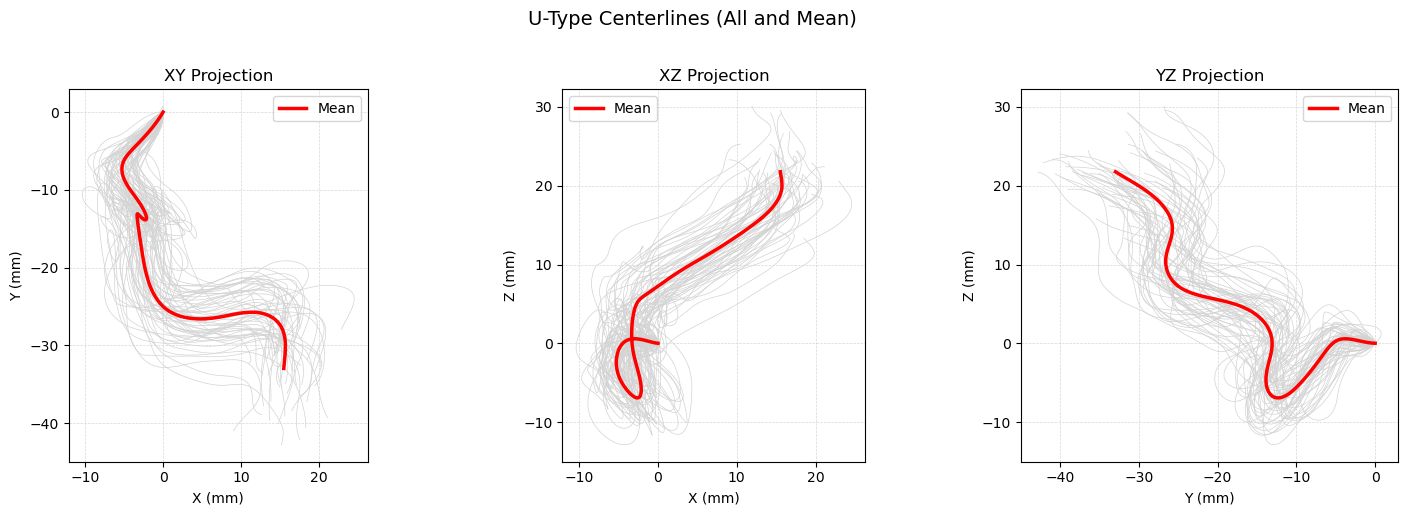

In [8]:
v

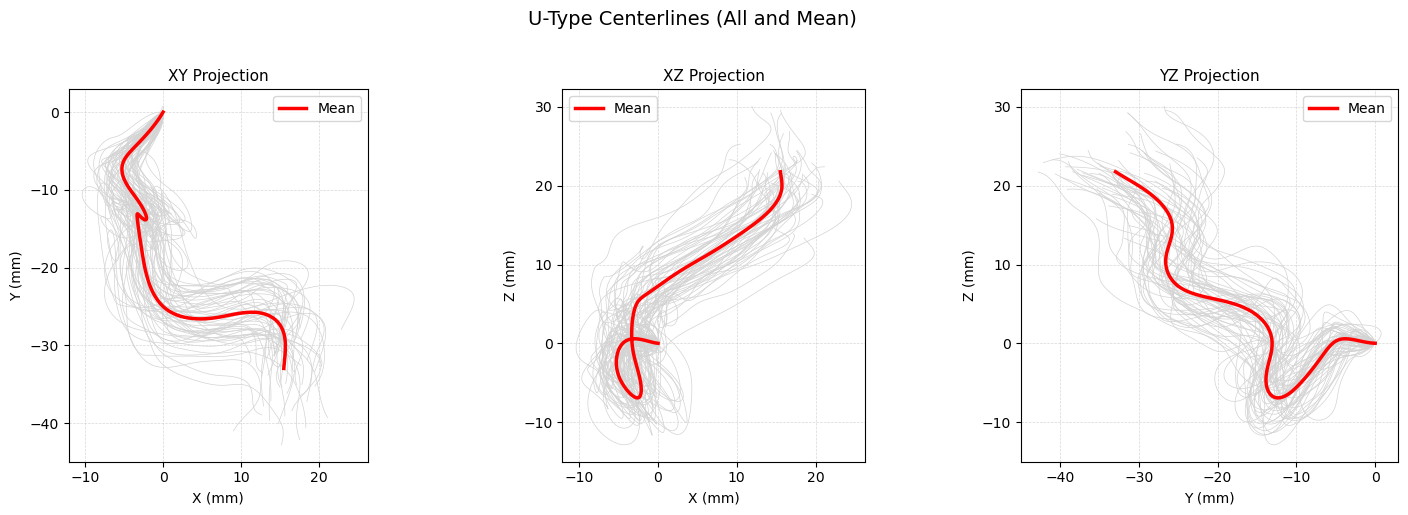

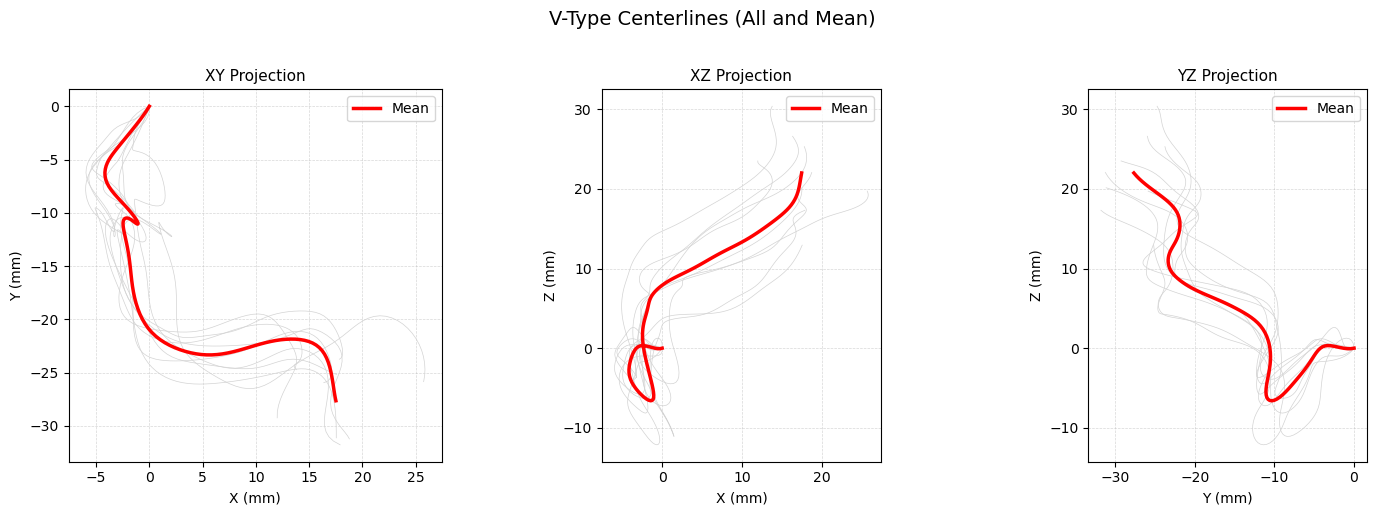

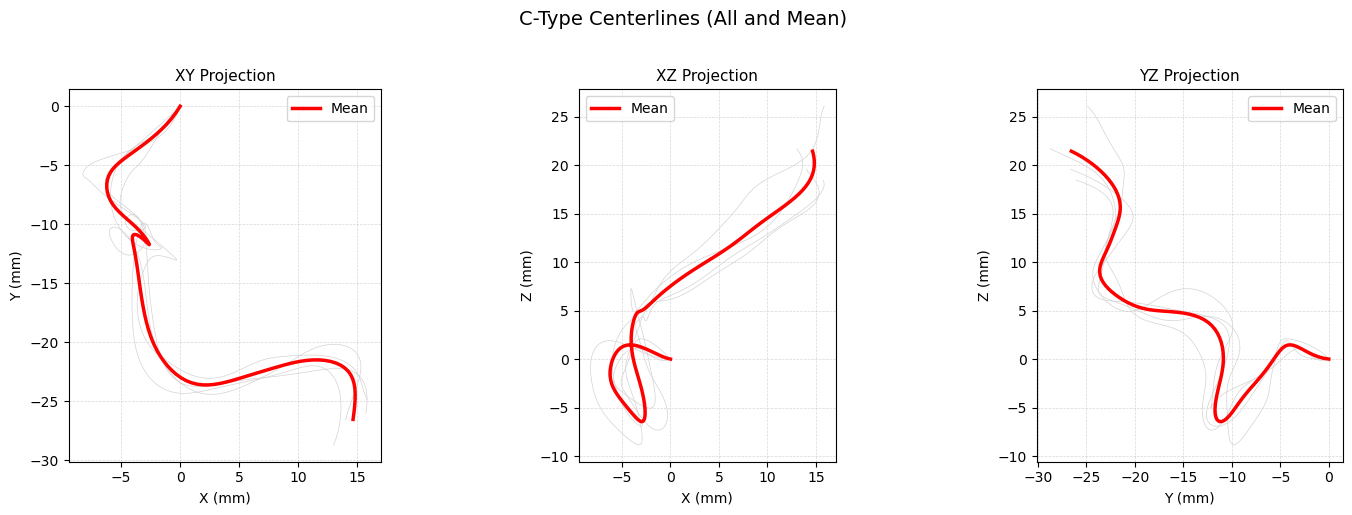

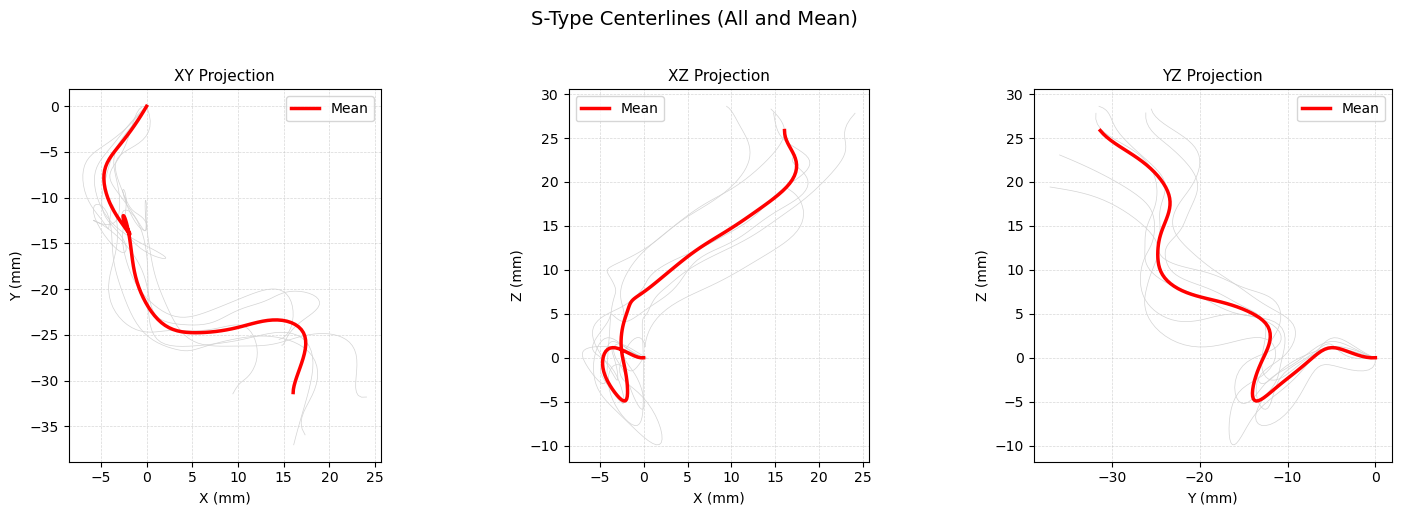

✅ 全部 U/V/C/S 类型可视化完成


In [9]:
import os, glob
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt

# === 输入路径 ===
base_dir = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\9_classification"
mean_dir = r"D:\github\Phd_summary\3_Result\1_Brava\1_Centerline\4_MeanCenterline"

# === 类别列表 ===
CLASSES = ["U", "V", "C", "S"]

def project_and_plot(ax, pts_list, mean_pts, plane, color_lines="lightgray", color_mean="red"):
    """绘制单个投影平面"""
    for pts in pts_list:
        if plane == "XY":
            ax.plot(pts[:, 0], pts[:, 1], color=color_lines, linewidth=0.5)
        elif plane == "XZ":
            ax.plot(pts[:, 0], pts[:, 2], color=color_lines, linewidth=0.5)
        elif plane == "YZ":
            ax.plot(pts[:, 1], pts[:, 2], color=color_lines, linewidth=0.5)

    # 平均中心线（红色）
    if plane == "XY":
        ax.plot(mean_pts[:, 0], mean_pts[:, 1], color=color_mean, linewidth=2.5, label="Mean")
    elif plane == "XZ":
        ax.plot(mean_pts[:, 0], mean_pts[:, 2], color=color_mean, linewidth=2.5, label="Mean")
    elif plane == "YZ":
        ax.plot(mean_pts[:, 1], mean_pts[:, 2], color=color_mean, linewidth=2.5, label="Mean")

    ax.set_xlabel(plane[0] + " (mm)")
    ax.set_ylabel(plane[1] + " (mm)")
    ax.set_title(f"{plane} Projection", fontsize=11)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
    ax.set_aspect("equal", adjustable="box")
    ax.legend()

# === 主循环 ===
for cls in CLASSES:
    cls_dir = os.path.join(base_dir, cls)
    vtk_files = sorted(glob.glob(os.path.join(cls_dir, "*.vtk")))
    mean_path = os.path.join(mean_dir, f"{cls}_mean.vtk")

    if not os.path.exists(mean_path):
        print(f"⚠ {cls}: 平均中心线不存在，跳过")
        continue

    # === 读取全部中心线 ===
    lines = []
    for f in vtk_files:
        line = pv.read(f)
        pts = line.points - line.points[0]  # 起点平移到原点
        lines.append(pts)

    mean_pts = pv.read(mean_path).points
    mean_pts = mean_pts - mean_pts[0]

    # === 绘制三视图 ===
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for ax, plane in zip(axes, ["XY", "XZ", "YZ"]):
        project_and_plot(ax, lines, mean_pts, plane)

    plt.suptitle(f"{cls}-Type Centerlines (All and Mean)", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

print("✅ 全部 U/V/C/S 类型可视化完成")


U: n=58, mean=75.88, std=8.12
V: n=9, mean=68.95, std=1.97
C: n=4, mean=71.75, std=1.83
S: n=6, mean=77.52, std=7.64


C:\Users\Harujane\AppData\Local\Temp\ipykernel_6500\3803387770.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


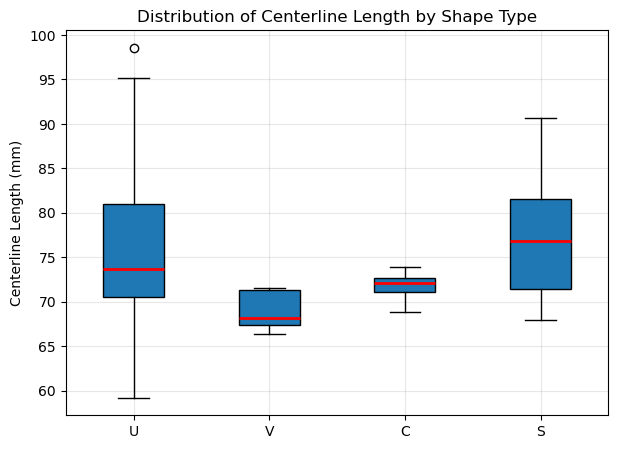

In [11]:
import os
import glob
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt

# === 路径设定 ===
base_dir = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\9_classification"
CLASSES = ["U", "V", "C", "S"]

def compute_length(points):
    """计算中心线长度"""
    diffs = np.diff(points, axis=0)
    seg_lengths = np.linalg.norm(diffs, axis=1)
    return np.sum(seg_lengths)

length_stats = {}

# === 计算每类中心线的长度 ===
for cls in CLASSES:
    vtk_files = sorted(glob.glob(os.path.join(base_dir, cls, "*.vtk")))
    lengths = []
    for f in vtk_files:
        pts = pv.read(f).points
        lengths.append(compute_length(pts))
    length_stats[cls] = np.array(lengths)
    print(f"{cls}: n={len(lengths)}, mean={np.mean(lengths):.2f}, std={np.std(lengths):.2f}")

# === 可视化（箱线图） ===
plt.figure(figsize=(7, 5))
colors = ["skyblue", "gold", "limegreen", "tomato"]

plt.boxplot(
    [length_stats[cls] for cls in CLASSES],
    labels=CLASSES,
    patch_artist=True,
    boxprops=dict(color="black"),
    medianprops=dict(color="red", linewidth=2)
)

for patch, color in zip(plt.gca().artists, colors):
    patch.set_facecolor(color)

plt.ylabel("Centerline Length (mm)")
plt.title("Distribution of Centerline Length by Shape Type")
plt.grid(alpha=0.3)

plt.show()
